In [1]:
import logging
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import optuna

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from pipelines import TreeSimilarPipeline
from split_data_type import SplitDataType
from teacher import Teacher

d:\Programming\Python\ML_Final_HousePredict\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(level=logging.DEBUG)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
submissions_path = Path("../submissions")
submissions_path.mkdir(parents=True, exist_ok=True)


target_column = "SalePrice"

train_df = pd.read_csv("../data/HousePrice_train.csv")
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]


X_test = pd.read_csv("../data/HousePrice_test.csv")
sample = pd.read_csv("../data/sample_submission.csv")

In [4]:
ensemble_valid_predicts = []
ensemble_test_predicts = []

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\Python\\ML_Final_HousePredict\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\Python\\ML_Final_HousePredict\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\Python\\ML_Final_HousePredict\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\Python\\ML_Final_HousePredict\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\Python\\ML_Final_HousePredict\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Pro

Axes(0.125,0.11;0.775x0.77)


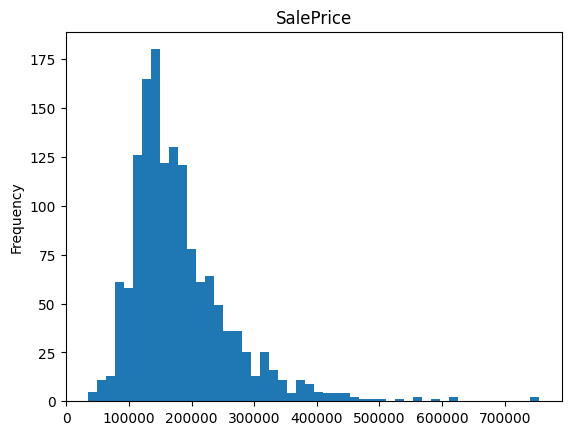

In [5]:
print(y_train.plot(kind="hist", bins=50, title="SalePrice"))

Axes(0.125,0.11;0.775x0.77)


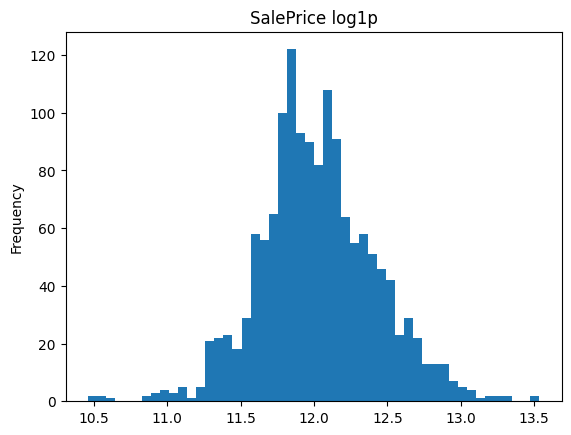

In [6]:
print(np.log1p(y_train).plot(kind="hist", bins=50, title="SalePrice log1p"))

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [8]:
label_encoder = LabelEncoder()
qt = QuantileTransformer(n_quantiles=4, output_distribution='uniform', random_state=0)
X_train = TreeSimilarPipeline(X_train, SplitDataType.TRAIN, label_encoder, quantile_transformer=qt).build()
X_valid = TreeSimilarPipeline(X_valid, SplitDataType.TEST, label_encoder, quantile_transformer=qt).build()
X_test = TreeSimilarPipeline(X_test, SplitDataType.TEST, label_encoder, quantile_transformer=qt).build()

DEBUG:root:TRAIN - Function: _drop_not_needed
Size: (1314, 73)
Columns with None: LotFrontage, Alley, MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Electrical, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature

DEBUG:root:TRAIN - Function: _fill_null
Size: (1314, 73)
Columns with None: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Electrical, FireplaceQu, GarageType, GarageQual, GarageCond, Fence

DEBUG:root:TRAIN - Function: _preprocess_features
Size: (1314, 73)
Columns with None: None

DEBUG:root:TRAIN - Function: _encode
Size: (1314, 73)
Columns with None: None

DEBUG:root:TRAIN - Function: _normalize
Size: (1314, 73)
Columns with None: None

DEBUG:root:TRAIN - Function: _drop_high_correlation
Size: (1314, 61)
Columns with None: None

DEBUG:root:TEST - Function: _drop_not_needed
Size: (146, 73)
Columns with None: LotFrontage, Alley, MasVnrType, BsmtQual, BsmtCond, BsmtExposur

# DecisionTreeRegressor

## Усі ознаки kaggle = 0.19732

In [9]:
tree = DecisionTreeRegressor(random_state=0, 
                             max_depth=8,
                             max_features=0.7,
                             min_samples_split=2,
                             min_samples_leaf=7)
tree_teacher = Teacher(tree, X_train, y_train)
print(tree_teacher.fit())
train_pred = tree_teacher.predict(X_train, y_train)
valid_pred = tree_teacher.predict(X_valid, y_valid)

sample[target_column] = tree_teacher.predict(X_test)
sample.to_csv(submissions_path / "tree_submission.csv", index=False)

DEBUG:root:Valid score RMSE: 40071.55544482875
DEBUG:root:Valid score RMSLE: 0.19623175712237173
DEBUG:root:RMSE:26791.707076630708
DEBUG:root:RMSLE:0.13303809443367165
DEBUG:root:RMSE:41214.3321330732
DEBUG:root:RMSLE:0.19295821807961716


0.8860888880705083


In [10]:
# params = {'max_depth': np.arange(4, 15, 1),
#           'max_features': np.arange(0.1, 1, 0.1),
#           'min_samples_split': np.arange(2, 4, 2),
#           'min_samples_leaf': np.arange(4, 8, 1),
#           }

# tree_teacher.search_params_by_grid(params, 'neg_root_mean_squared_error')

In [11]:
tree_teacher.show_feature_importances(X_train)

                      Feature  Importance
11                  ExterQual    0.440925
6                 OverallQual    0.231787
19                TotalBsmtSF    0.069288
35                 GarageArea    0.047382
1                     LotArea    0.039135
22                   2ndFlrSF    0.036833
21                   1stFlrSF    0.029373
57             Is_central_air    0.026586
26                   FullBath    0.013235
17                 BsmtFinSF1    0.012700
31               TotRmsAbvGrd    0.008978
38                OpenPorchSF    0.007970
0                 LotFrontage    0.006311
7                 OverallCond    0.004858
3                Neighborhood    0.003977
8                YearRemodAdd    0.003163
14                   BsmtQual    0.003129
18                  BsmtUnfSF    0.002928
24               BsmtFullBath    0.002538
28               BedroomAbvGr    0.002537
36                 GarageCond    0.002192
9                 Exterior1st    0.002170
13                 Foundation    0

## Без неінформативних ознак kaggle = 0.20232

In [12]:
tree = DecisionTreeRegressor(random_state=0, 
                             max_depth=11,
                             max_features=0.9,
                             min_samples_split=2,
                             min_samples_leaf=7)
uninformed_features = ['ExterCond', 'HalfBath', 'BsmtHalfBath', 'LowQualFinSF', 
                       'HeatingQC', 'BsmtExposure', 'BsmtCond', 'BldgType', 
                       'KitchenAbvGr', 'GarageType', 'GarageFinish', 'Fence', 
                       'MoSold', 'YrSold', 'SaleType', 'WithAlley', 'KitchenQual', 
                       'WithPool', 'WithFeature', 'Is_typical_functional', 
                       'Is_finished_bsmt_fintype2', 'Is_gable_roofstyle', 
                       'Is_norm_condition1', 'Is_normal_sale_condition', 
                       'Is_standard_electrical', 'Is_reg_lotshape', 
                       'Is_residential_mszoning', 'Is_paved', 'Is_Gtl_landslope', 
                       'Is_level_landContour', 'Is_enclosedporch', 
                       'Is_3ssnporch', 'Is_screenporch']
tree_teacher = Teacher(tree, X_train, y_train, uniformed_features=uninformed_features)
print(tree_teacher.fit())
train_pred = tree_teacher.predict(X_train, y_train)
valid_pred = tree_teacher.predict(X_valid, y_valid)

sample[target_column] = tree_teacher.predict(X_test)
sample.to_csv(submissions_path / "tree_shap_submission.csv", index=False)

DEBUG:root:Valid score RMSE: 39682.96861252666
DEBUG:root:Valid score RMSLE: 0.1921955170828137
DEBUG:root:RMSE:24496.26269973209
DEBUG:root:RMSLE:0.12064123253601876
DEBUG:root:RMSE:40110.52030653504
DEBUG:root:RMSLE:0.1913559367215558


0.9063289063238215


In [13]:
# params = {'max_depth': np.arange(2, 15, 1),
#           'max_features': np.arange(0.1, 1, 0.1),
#           'min_samples_split': np.arange(2, 4, 1),
#           'min_samples_leaf': np.arange(2, 12, 1),
#           }

# tree_teacher.search_params_by_grid(params, 'neg_root_mean_squared_error')

# RandomForest

## Усі ознаки kaggle = 0.15479

In [14]:
forest = RandomForestRegressor(random_state=0,
                               max_depth=10,
                               n_estimators=950,
                               )
forest_teacher = Teacher(forest, X_train, y_train)
print(forest_teacher.fit())
train_pred = forest_teacher.predict(X_train, y_train)
valid_pred = forest_teacher.predict(X_valid, y_valid)

sample[target_column] = forest_teacher.predict(X_test)
sample.to_csv(submissions_path / "forest_submission.csv", index=False)

DEBUG:root:Valid score RMSE: 30707.955219838164
DEBUG:root:Valid score RMSLE: 0.14720199587802457


0.9731038776725759


DEBUG:root:RMSE:13348.383490877211
DEBUG:root:RMSLE:0.06464542659750946
DEBUG:root:RMSE:44449.94685558944
DEBUG:root:RMSLE:0.15285874104950473


In [15]:
# params = {'max_depth': np.arange(4, 12, 2),
#           'n_estimators': np.arange(400, 1000, 50),
#           }

# forest_teacher.search_params_by_grid(params, 'neg_root_mean_squared_error')

In [16]:
forest_teacher.show_feature_importances(X_train)

                      Feature  Importance
6                 OverallQual    0.590675
35                 GarageArea    0.075269
21                   1stFlrSF    0.039921
19                TotalBsmtSF    0.036192
1                     LotArea    0.030189
22                   2ndFlrSF    0.024792
17                 BsmtFinSF1    0.023683
26                   FullBath    0.020216
32                 Fireplaces    0.017267
8                YearRemodAdd    0.012004
0                 LotFrontage    0.011186
57             Is_central_air    0.010883
31               TotRmsAbvGrd    0.009331
7                 OverallCond    0.008167
3                Neighborhood    0.007754
38                OpenPorchSF    0.006672
18                  BsmtUnfSF    0.006274
37                 WoodDeckSF    0.004577
33                 GarageType    0.004369
40                     MoSold    0.004357
34               GarageFinish    0.003853
10                 MasVnrArea    0.003811
28               BedroomAbvGr    0

## Без неінформативних ознак kaggle = 0.1488))

In [17]:
forest = RandomForestRegressor(random_state=0,
                               max_depth=10,
                               min_samples_leaf=1,
                               min_samples_split=2,
                               n_estimators=675,
                               max_features=0.4,
                               )
uninformed_features = ['HalfBath', 'HeatingQC', 'BsmtExposure', 'YrSold', 
                       'BldgType', 'KitchenQual', 'Fence', 'BsmtCond', 'Foundation', 
                       'Is_normal_sale_condition', 'Is_paved', 'Is_reg_lotshape', 
                       'ExterQual', 'Is_Gtl_landslope', 'WithAlley', 'BsmtFullBath', 
                       'SaleType', 'Is_gable_roofstyle', 'Is_level_landContour', 
                       'HouseStyle', 'Is_enclosedporch', 'LotConfig', 'Is_typical_functional', 
                       'KitchenAbvGr', 'Is_norm_condition1', 'Is_screenporch', 
                       'Is_standard_electrical', 'Is_finished_bsmt_fintype2', 
                       'BsmtHalfBath', 'Is_3ssnporch', 'WithFeature', 'WithPool', 
                       'LowQualFinSF']
forest_teacher = Teacher(forest, X_train, y_train, uniformed_features=uninformed_features)
print(forest_teacher.fit())
train_pred = forest_teacher.predict(X_train, y_train)
valid_pred = forest_teacher.predict(X_valid, y_valid)

sample[target_column] = forest_teacher.predict(X_test)
sample.to_csv(submissions_path / "forest_shap_submission.csv", index=False)

DEBUG:root:Valid score RMSE: 30281.558608774234
DEBUG:root:Valid score RMSLE: 0.14286854877640623
DEBUG:root:RMSE:13627.330374175395
DEBUG:root:RMSLE:0.0663626072026724


0.9716560130278704


DEBUG:root:RMSE:45553.663967033375
DEBUG:root:RMSLE:0.15244491384264547


In [18]:
# params = {'max_depth': np.arange(2, 11, 2),
#           'n_estimators': np.arange(400, 1100, 25),
#           'min_samples_split': np.arange(2, 3, 2),
#           'min_samples_leaf': np.arange(1, 3, 1),
#           'max_features': np.arange(0.3, 0.5, 0.05),
#           }

# forest_teacher.search_params_by_grid(params, 'neg_root_mean_squared_error')

# XGBoost

## Усі ознаки kaggle = 0.13591

In [19]:
xgboost = XGBRegressor(random_state=0, 
                       max_depth=5,
                       n_estimators=1000,
                       learning_rate=0.010018,
                       subsample=0.556547,
                       colsample_bytree=0.5858071,
                       gamma=0.001783,
                       min_child_weight=11,
                       alpha=0.373666,
                       reg_lambda=0.16301251,
                       colsample_bylevel=0.67545835,
                       colsample_bynode=0.59074260,
                       scale_pos_weight=0.6309540,
                       max_delta_step=8,
                       max_leaves=34,
                       )
xgboost_teacher = Teacher(xgboost, X_train, y_train)
print(xgboost_teacher.fit())
train_pred = xgboost_teacher.predict(X_train, y_train)
valid_pred = xgboost_teacher.predict(X_valid, y_valid)

sample[target_column] = xgboost_teacher.predict(X_test)
sample.to_csv(submissions_path / "xgboost_submission.csv", index=False)

DEBUG:root:Valid score RMSE: 27438.910310411196
DEBUG:root:Valid score RMSLE: 0.12983962639667926
DEBUG:root:RMSE:16924.012762935392
DEBUG:root:RMSLE:0.08622172614823705
DEBUG:root:RMSE:38155.518395115534
DEBUG:root:RMSLE:0.13643533076598968


0.9521538080451776


In [20]:
def objective(trial):
    params = {
        "random_state": 42,
        "max_depth": trial.suggest_int("max_depth", 2, 14),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500, step=25),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 25),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "alpha": trial.suggest_float("alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 2.0),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "max_leaves": trial.suggest_int("max_leaves", 0, 64),
    }

    model = XGBRegressor(**params)
    
    score = cross_val_score(
        model, xgboost_teacher.X_train, np.log1p(y_train),
        cv=KFold(n_splits=3, shuffle=True, random_state=42), 
        scoring="neg_root_mean_squared_error"
    ).mean()
    
    return score

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=200, n_jobs=-1)
# print("Найкращі параметри:", study.best_params)
# print("Найкраща точність:", -study.best_value)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x000001BC82316900>
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\Python\\ML_Final_HousePredict\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\Python\\ML_Final_HousePredict\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Programming\\Python\\ML_Final_HousePredict\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\f

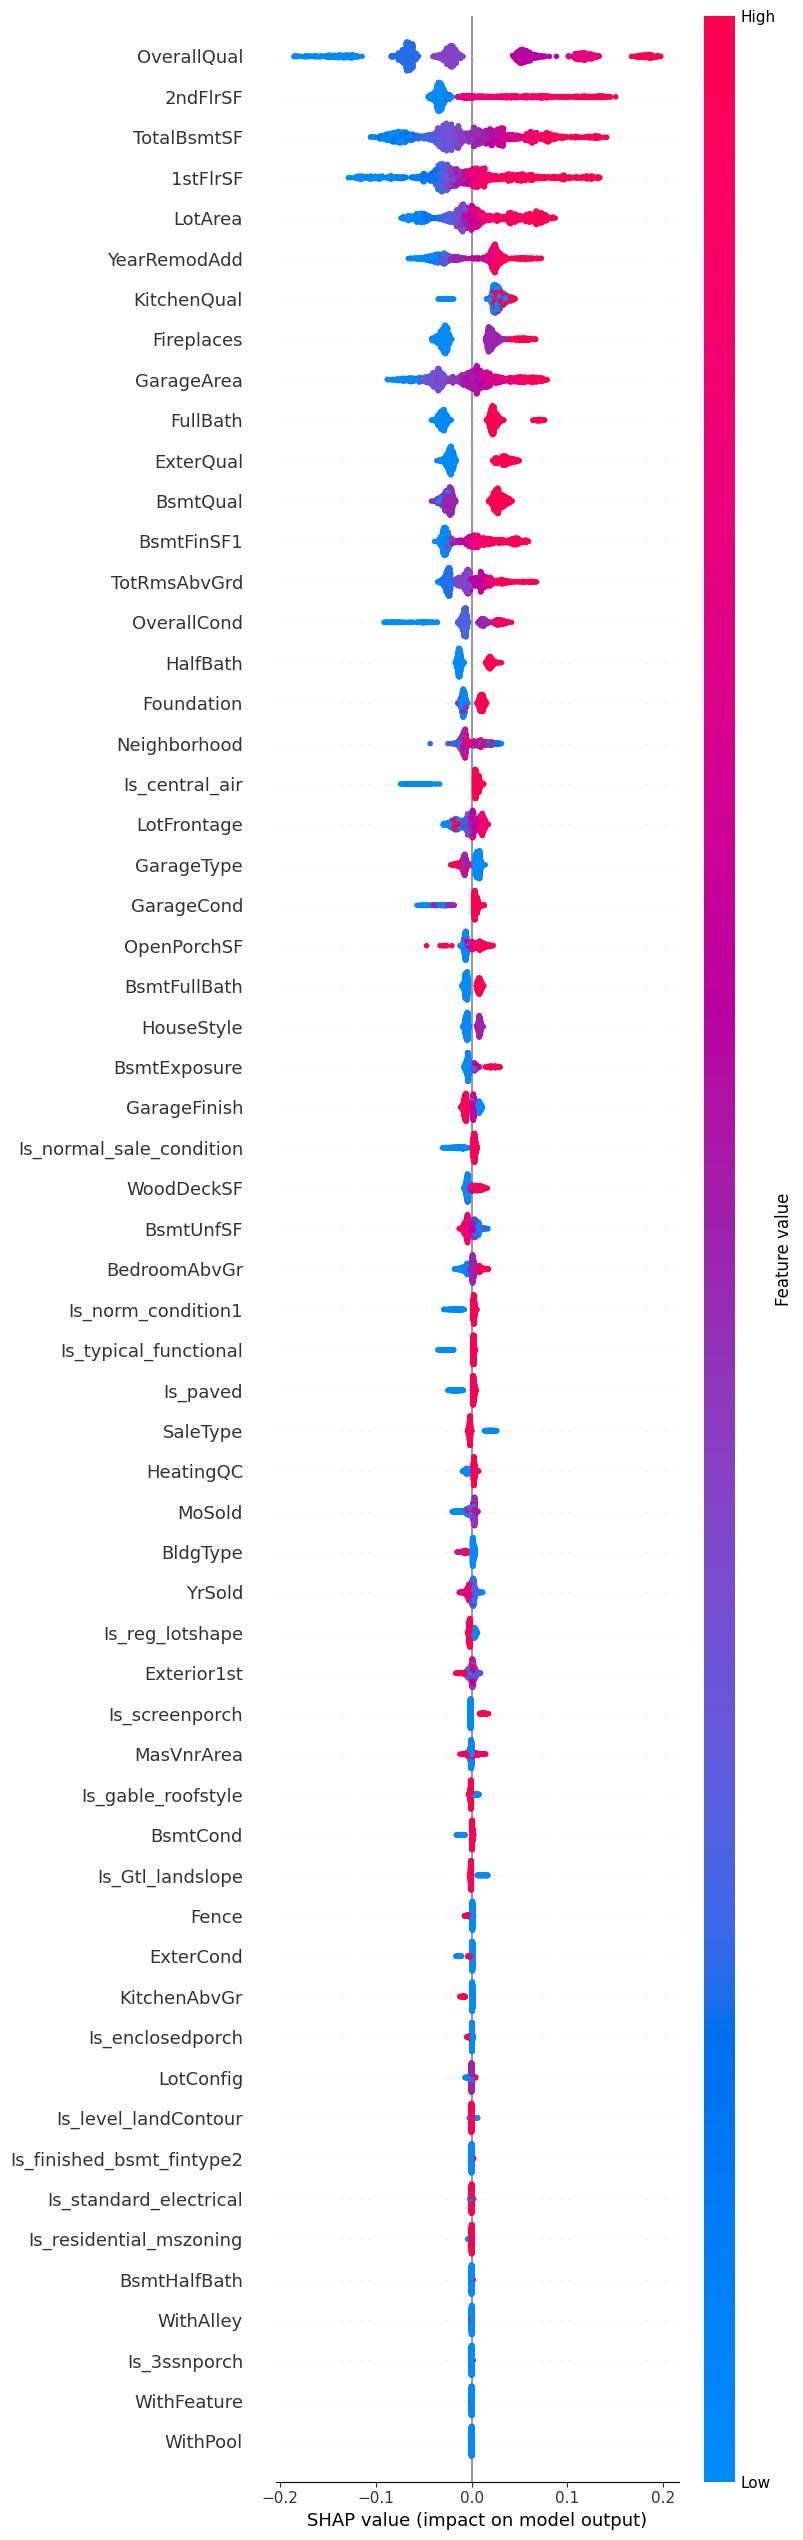

DEBUG:root:Index(['OverallQual', '2ndFlrSF', 'TotalBsmtSF', '1stFlrSF', 'LotArea',
       'YearRemodAdd', 'KitchenQual', 'Fireplaces', 'GarageArea', 'FullBath',
       'ExterQual', 'BsmtQual', 'BsmtFinSF1', 'TotRmsAbvGrd', 'OverallCond',
       'HalfBath', 'Foundation', 'Neighborhood', 'Is_central_air',
       'LotFrontage', 'GarageType', 'GarageCond', 'OpenPorchSF',
       'BsmtFullBath', 'HouseStyle', 'BsmtExposure', 'GarageFinish',
       'Is_normal_sale_condition', 'WoodDeckSF', 'BsmtUnfSF', 'BedroomAbvGr',
       'Is_norm_condition1', 'Is_typical_functional', 'Is_paved', 'SaleType',
       'HeatingQC', 'MoSold', 'BldgType', 'YrSold', 'Is_reg_lotshape',
       'Exterior1st', 'Is_screenporch', 'MasVnrArea', 'Is_gable_roofstyle',
       'BsmtCond', 'Is_Gtl_landslope', 'Fence', 'ExterCond', 'KitchenAbvGr',
       'Is_enclosedporch', 'LotConfig', 'Is_level_landContour',
       'Is_finished_bsmt_fintype2', 'Is_standard_electrical',
       'Is_residential_mszoning', 'BsmtHalfBath', 'With

In [21]:
xgboost_teacher.show_shap(X_test)

## Без неінформативних ознак kaggle = 0.13696
## З booster='dart' = 0.13688

In [22]:
xgboost = XGBRegressor(random_state=0, 
                       max_depth=6,
                       n_estimators=1350,
                       learning_rate=0.010788,
                       subsample=0.887236875,
                       colsample_bytree=0.59352042,
                       gamma=0.00114149,
                       min_child_weight=23,
                       alpha=0.23008054,
                       reg_lambda=3.2027897,
                       colsample_bylevel=0.6429693,
                       colsample_bynode=0.712897893,
                       scale_pos_weight=0.8320001,
                       max_delta_step=1,
                       max_leaves=15,
                       )
uninformed_features = ['Is_gable_roofstyle',
       'Is_Gtl_landslope', 'BsmtCond', 'Fence', 'KitchenAbvGr', 'ExterCond',
       'Is_enclosedporch', 'Is_level_landContour', 'LotConfig', 'WithAlley',
       'Is_standard_electrical', 'Is_finished_bsmt_fintype2',
       'Is_residential_mszoning', 'BsmtHalfBath', 'Is_3ssnporch',
       'WithFeature', 'WithPool']
xgboost_teacher = Teacher(xgboost, X_train, y_train, uniformed_features=uninformed_features)
print(xgboost_teacher.fit())
train_pred = xgboost_teacher.predict(X_train, y_train)
valid_pred = xgboost_teacher.predict(X_valid, y_valid)
test_pred = xgboost_teacher.predict(X_test)
sample[target_column] = test_pred
sample.to_csv(submissions_path / "xgboost_shap_submission.csv", index=False)

ensemble_valid_predicts.append(valid_pred)
ensemble_test_predicts.append(test_pred)

DEBUG:root:Valid score RMSE: 27411.93363270046
DEBUG:root:Valid score RMSLE: 0.1296289341464671
DEBUG:root:RMSE:15664.874337191473
DEBUG:root:RMSLE:0.0793730703254488
DEBUG:root:RMSE:38239.40417945865
DEBUG:root:RMSLE:0.1368412695000224


0.9594528527378022


In [23]:
def objective(trial):
    params = {
        "random_state": 42,
        "max_depth": trial.suggest_int("max_depth", 2, 14),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500, step=25),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 25),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "alpha": trial.suggest_float("alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 2.0),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "max_leaves": trial.suggest_int("max_leaves", 0, 64),
    }

    model = XGBRegressor(**params)
    
    score = cross_val_score(
        model, xgboost_teacher.X_train, np.log1p(y_train),
        cv=KFold(n_splits=3, shuffle=True, random_state=42), 
        scoring="neg_root_mean_squared_error"
    ).mean()
    
    return score

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100, n_jobs=-1)
# print("Найкращі параметри:", study.best_params)
# print("Найкраща точність:", -study.best_value)

# LGBM

## Усі ознаки kaggle = 0.13358

In [24]:
lgbmboost = LGBMRegressor(random_state=0,
                          learning_rate=0.0073547,
                          max_depth=6,
                          n_estimators=1750,
                          num_leaves=68,
                          min_child_samples=12,
                          min_child_weight=0.09448,
                          reg_alpha=0.15426462,
                          reg_lambda=2.50585,
                          subsample=0.5299720,
                          subsample_freq=8,
                          colsample_bytree=0.572721,
                          bagging_fraction=0.5072504,
                          bagging_freq=8,
                          drop_rate=0.3237,
                          skip_drop=0.614534,
                          max_drop=92,
                       )
lgbmboost_teacher = Teacher(lgbmboost, X_train, y_train)
print(lgbmboost_teacher.fit())
train_pred = lgbmboost_teacher.predict(X_train, y_train)
valid_pred = lgbmboost_teacher.predict(X_valid, y_valid)
test_pred = lgbmboost_teacher.predict(X_test)
sample[target_column] = test_pred
sample.to_csv(submissions_path / "lgbmboost_submission.csv", index=False)

ensemble_valid_predicts.append(valid_pred)
ensemble_test_predicts.append(test_pred)

[LightGBM] [Warning] bagging_fraction is set=0.5072504, subsample=0.529972 will be ignored. Current value: bagging_fraction=0.5072504
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=8 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5072504, subsample=0.529972 will be ignored. Current value: bagging_fraction=0.5072504
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=8 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2368
[LightGBM] [Info] Number of data points in the train set: 1051, number of used features: 60
[LightGBM] [Info] Start training from score 12.025606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

d:\Programming\Python\ML_Final_HousePredict\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Programming\Python\ML_Final_HousePredict\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\Atheus\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Atheus\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in __i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

DEBUG:root:Valid score RMSE: 26996.886379321553
DEBUG:root:Valid score RMSLE: 0.12885548700610794


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

DEBUG:root:RMSE:13953.891987976422
DEBUG:root:RMSLE:0.06880778349580234
DEBUG:root:RMSE:40021.2080972874
DEBUG:root:RMSLE:0.13807591470438865



[LightGBM] [Warning] bagging_fraction is set=0.5072504, subsample=0.529972 will be ignored. Current value: bagging_fraction=0.5072504
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=8 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5072504, subsample=0.529972 will be ignored. Current value: bagging_fraction=0.5072504
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=8 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5072504, subsample=0.529972 will be ignored. Current value: bagging_fraction=0.5072504
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=8 will be ignored. Current value: bagging_freq=8


In [25]:
def objective(trial):
    params = {
        "random_state": 42,
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=25),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 0, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
        "drop_rate": trial.suggest_float("drop_rate", 0.01, 0.5),
        "skip_drop": trial.suggest_float("skip_drop", 0.01, 0.9),
        "max_drop": trial.suggest_int("max_drop", 10, 100),
    }

    model = LGBMRegressor(**params)
    
    score = cross_val_score(
        model, lgbmboost_teacher.X_train, np.log1p(y_train),
        cv=KFold(n_splits=3, shuffle=True, random_state=42), 
        scoring="neg_root_mean_squared_error"
    ).mean()
    
    return score

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100, n_jobs=-1)
# print("Найкращі параметри:", study.best_params)
# print("Найкраща точність:", -study.best_value)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x000001BC99208050>


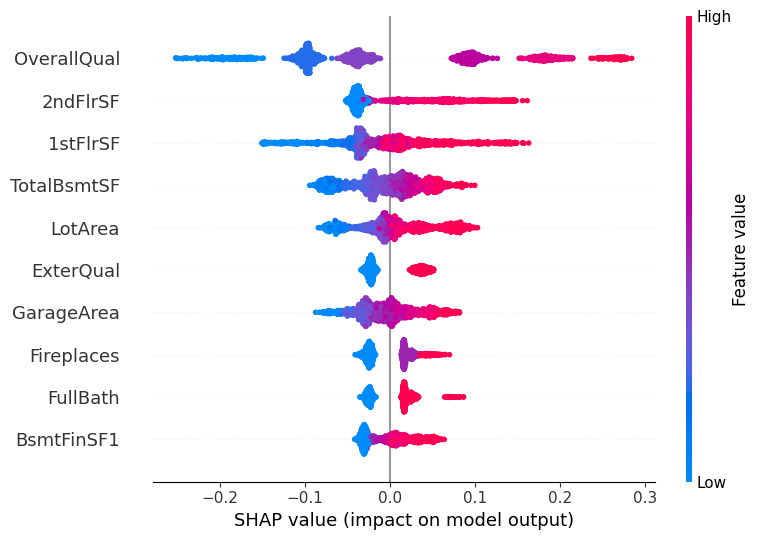

DEBUG:root:Index(['OverallQual', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF', 'LotArea',
       'ExterQual', 'GarageArea', 'Fireplaces', 'FullBath', 'BsmtFinSF1'],
      dtype='object')


In [26]:
lgbmboost_teacher.show_shap(X_test, 10)

## ансамбль з двух - стало гірше kaggle = 0.13465

In [27]:
total_valid_pred = sum(ensemble_valid_predicts) / len(ensemble_valid_predicts)
total_test_pred = sum(ensemble_test_predicts) / len(ensemble_test_predicts)

In [28]:
print(np.sqrt(mean_squared_error(y_valid, total_valid_pred)))

38996.58804789374


In [29]:
sample[target_column] = total_test_pred
sample.to_csv(submissions_path / "total_submission.csv", index=False)